<a href="https://colab.research.google.com/github/RochaErik/AlgorithmComparison/blob/main/AlgorithmComparison3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# **Evaluating algorithms with hyperparameter tuning**

---

In [115]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import scipy.stats as stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [117]:
!pip install hyperopt

In [118]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# **Wine Dataset**

In [119]:
wine_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Wine\wine.data', header=None)

In [120]:
X = wine_df.iloc[:, 1:]
y = wine_df.iloc[:, 0]

In [121]:
le = LabelEncoder()
y = le.fit_transform(y)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [123]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

  2%|▏         | 1/50 [00:00<00:11,  4.42trial/s, best loss: -0.9722222222222222]

100%|██████████| 50/50 [00:24<00:00,  2.04trial/s, best loss: -1.0]              
Best hyperparameters for AdaBoost:
{'n_estimators': 200.0, 'learning_rate': 0.06659352635164861, 'max_depth': 4.0, 'max_features': 'sqrt', 'min_samples_leaf': 3.0, 'min_samples_split': 2.0, 'random_state': 42}
100%|██████████| 50/50 [01:11<00:00,  1.42s/trial, best loss: -1.0]              
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.04102652661864284, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0, 'min_impurity_decrease': 1.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [02:30<00:00,  3.01s/trial, best loss: -1.0]
Best hyperparameters for CatBoost:
{'n_estimators': 550, 'learning_rate': 0.0479901225935416, 'min_child_samples': 1, 'max_depth': 6, 'reg_lambda': 3.3766279624518107, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 [00:01<00:00, 31.4

In [124]:
best_hyperparams['AdaBoost']

{'n_estimators': 200.0,
 'learning_rate': 0.06659352635164861,
 'max_depth': 4.0,
 'max_features': 'sqrt',
 'min_samples_leaf': 3.0,
 'min_samples_split': 2.0,
 'random_state': 42}

In [ ]:
best_hyperparams['GradBoost']

{'criterion': 'friedman_mse',
 'max_features': 'sqrt',
 'n_estimators': 100,
 'learning_rate': 0.04102652661864284,
 'max_depth': 3,
 'min_samples_split': 7,
 'min_samples_leaf': 7,
 'min_weight_fraction_leaf': 0.0,
 'min_impurity_decrease': 1.0,
 'ccp_alpha': 0.0,
 'random_state': 42}

In [ ]:
best_hyperparams['CatBoost']

{'n_estimators': 550,
 'learning_rate': 0.0479901225935416,
 'min_child_samples': 1,
 'max_depth': 6,
 'reg_lambda': 3.3766279624518107,
 'silent': True,
 'random_state': 42}

In [ ]:
best_hyperparams['LightGBM']

{'class_weight': 'balanced',
 'boosting_type': 'gbdt',
 'num_leaves': 55,
 'learning_rate': 0.04496177447997528,
 'min_child_samples': 10,
 'reg_alpha': 0.3916912792044354,
 'reg_lambda': 1.4941077467431771,
 'colsample_by_tree': 0.379259630420579,
 'verbosity': -1,
 'random_state': 42}

In [ ]:
best_hyperparams['XGBoost']

{'booster': 'dart',
 'learning_rate': 0.09292666170093178,
 'gamma': 4,
 'max_depth': 4,
 'min_child_weight': 1,
 'colsample_bytree': 0.8943278668489419,
 'colsample_bylevel': 0.2640104690942444,
 'colsample_bynode': 0.8937107554719765,
 'reg_alpha': 0.056770729092546546,
 'reg_lambda': 4.219736540591216,
 'random_state': 42}

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [ ]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [ ]:
wine_scores = []
wine_scores_mean = []
wine_scores_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)
        
    start_time = time.time()    
    results = cross_val_score(clf, X, y, cv=rskf)
    end_time = time.time()
    wine_scores.append(results)
    wine_scores_mean.append(results.mean()*100)
    wine_scores_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)

    print(f'--------- {algorithm_name} on Wine Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on Wine Dataset ---------
[0.94444444 0.94444444 0.94444444 1.         0.94444444 1.
 1.         0.83333333 1.         1.         1.         1.
 0.94444444 1.         0.94444444 1.         1.         0.88888889
 1.         0.94117647 1.         1.         0.88888889 0.94444444
 1.         1.         1.         1.         0.88235294 1.
 0.94444444 1.         1.         0.94444444 1.         0.94444444
 1.         1.         0.94117647 0.88235294 0.88888889 1.
 1.         0.94444444 1.         1.         1.         1.
 0.82352941 0.94117647 1.         0.94444444 1.         0.94444444
 1.         1.         0.94444444 0.94444444 0.94117647 0.94117647
 1.         1.         0.94444444 1.         1.         0.88888889
 0.94444444 0.94444444 0.88235294 1.         0.94444444 1.
 1.         0.94444444 1.         1.         0.94444444 0.94444444
 0.94117647 0.94117647 1.         1.         1.         0.94444444
 1.         0.94444444 0.94444444 1.         0.94117647 1.
 0.944

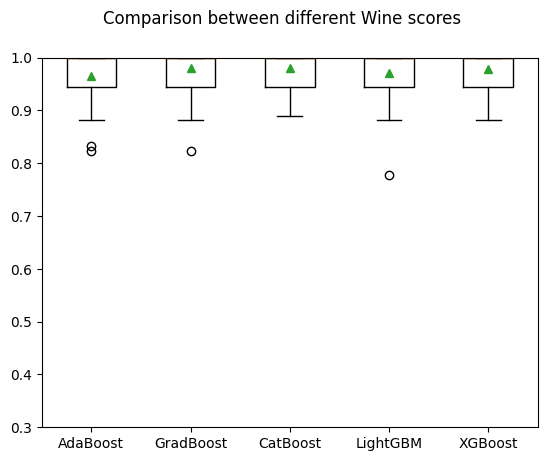

In [180]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Wine scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(wine_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [181]:
Algo_results = pd.DataFrame()
Algo_results['Names'] = names

In [182]:
Algo_results['Wine'] = wine_scores_mean

In [183]:
Algo_results

,Names,Wine
0,AdaBoost,96.552288
1,GradBoost,98.075163
2,CatBoost,97.967320
3,LightGBM,97.120915
4,XGBoost,97.797386


In [184]:
Algo_time_results = pd.DataFrame()
Algo_time_results['Names'] = names

In [185]:
Algo_time_results['Wine'] = pd.Series(execution_times)

In [186]:
Algo_time_results

,Names,Wine
0,AdaBoost,22.876993
1,GradBoost,16.068150
2,CatBoost,97.146326
3,LightGBM,3.337753
4,XGBoost,40.201234


---

# **Breast Cancer Dataset**

---

In [187]:
breast_cancer_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\BreastCancer\Breast.dat', sep=',', header=None)

In [188]:
X = breast_cancer_df.iloc[:, :-1]
y = breast_cancer_df.iloc[:, -1]

In [189]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [191]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [00:40<00:00,  1.24trial/s, best loss: -0.9927007299270073]
Best hyperparameters for AdaBoost:
{'n_estimators': 450.0, 'learning_rate': 0.01199453123793802, 'max_depth': 4.0, 'max_features': 'log2', 'min_samples_leaf': 4.0, 'min_samples_split': 6.0, 'random_state': 42}
100%|██████████| 50/50 [00:16<00:00,  2.99trial/s, best loss: -0.9927007299270073]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': 'sqrt', 'n_estimators': 550, 'learning_rate': 0.0611622198189229, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 1.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [00:34<00:00,  1.44trial/s, best loss: -0.9927007299270073]
Best hyperparameters for CatBoost:
{'n_estimators': 300, 'learning_rate': 0.013094250183297027, 'min_child_samples': 1, 'max_depth': 5, 'reg_lambda': 4.710165866797953, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 [

In [192]:
best_hyperparams['AdaBoost']

{'n_estimators': 450.0,
 'learning_rate': 0.01199453123793802,
 'max_depth': 4.0,
 'max_features': 'log2',
 'min_samples_leaf': 4.0,
 'min_samples_split': 6.0,
 'random_state': 42}

In [193]:
best_hyperparams['GradBoost']

{'criterion': 'friedman_mse',
 'max_features': 'sqrt',
 'n_estimators': 550,
 'learning_rate': 0.0611622198189229,
 'max_depth': 2,
 'min_samples_split': 7,
 'min_samples_leaf': 5,
 'min_weight_fraction_leaf': 0.1,
 'min_impurity_decrease': 1.0,
 'ccp_alpha': 0.0,
 'random_state': 42}

In [194]:
best_hyperparams['CatBoost']

{'n_estimators': 300,
 'learning_rate': 0.013094250183297027,
 'min_child_samples': 1,
 'max_depth': 5,
 'reg_lambda': 4.710165866797953,
 'silent': True,
 'random_state': 42}

In [195]:
best_hyperparams['LightGBM']

{'class_weight': 'balanced',
 'boosting_type': 'goss',
 'num_leaves': 70,
 'learning_rate': 0.06466735422122151,
 'min_child_samples': 60,
 'reg_alpha': 1.7712918439651535,
 'reg_lambda': 0.09630512995808138,
 'colsample_by_tree': 0.9773212695265424,
 'verbosity': -1,
 'random_state': 42}

In [196]:
best_hyperparams['XGBoost']

{'booster': 'dart',
 'learning_rate': 0.01958151011028328,
 'gamma': 5,
 'max_depth': 3,
 'min_child_weight': 3,
 'colsample_bytree': 0.17755828466772988,
 'colsample_bylevel': 0.2750454258060418,
 'colsample_bynode': 0.5404751722067938,
 'reg_alpha': 1.5842037921731331,
 'reg_lambda': 1.1583230510671016,
 'random_state': 42}

In [197]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [198]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [199]:
breast_cancer_scores = []
breast_cancer_mean = []
breast_cancer_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)

    start_time = time.time()    
    results = cross_val_score(clf, X, y, cv=rskf)
    end_time = time.time()
    breast_cancer_scores.append(results)
    breast_cancer_mean.append(results.mean()*100)
    breast_cancer_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)

    print(f'--------- {algorithm_name} on Breast Cancer Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on Breast Cancer Dataset ---------
[0.95652174 0.97101449 0.92753623 0.95588235 0.97058824 1.
 0.97058824 0.97058824 0.98529412 0.98529412 0.97101449 0.95652174
 0.95652174 0.98529412 0.95588235 0.95588235 1.         0.97058824
 0.98529412 0.97058824 1.         0.95652174 0.97101449 0.98529412
 0.95588235 0.98529412 0.97058824 0.98529412 0.97058824 0.97058824
 0.98550725 0.94202899 0.98550725 0.97058824 0.98529412 1.
 0.97058824 0.98529412 0.94117647 0.95588235 0.95652174 0.98550725
 0.98550725 1.         0.98529412 0.97058824 0.97058824 0.98529412
 0.95588235 0.94117647 0.98550725 0.92753623 1.         1.
 0.94117647 0.98529412 0.97058824 0.98529412 0.97058824 0.97058824
 0.95652174 0.98550725 0.98550725 0.91176471 0.98529412 0.98529412
 0.94117647 0.97058824 0.92647059 1.         0.95652174 1.
 0.97101449 0.95588235 0.98529412 0.94117647 0.98529412 0.98529412
 0.95588235 0.97058824 0.97101449 0.97101449 0.97101449 0.97058824
 0.98529412 0.95588235 0.97058824 0.9705

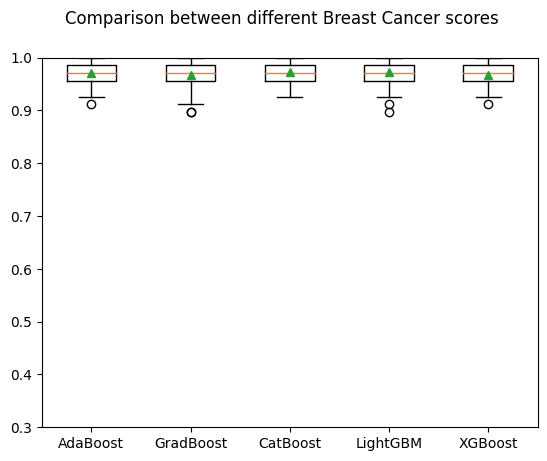

In [200]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Breast Cancer scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(breast_cancer_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [201]:
Algo_results['Breast_Cancer'] = breast_cancer_mean

In [202]:
Algo_results

,Names,Wine,Breast_Cancer
0,AdaBoost,96.552288,97.159847
1,GradBoost,98.075163,96.646633
2,CatBoost,97.967320,97.378303
3,LightGBM,97.120915,97.334612
4,XGBoost,97.797386,96.792626


In [203]:
Algo_time_results['Breast_Cancer'] = pd.Series(execution_times)

---

# **Sonar Dataset** #

---

In [204]:
sonar_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Sonar\Sonar.csv', header=None)

In [205]:
X = sonar_df.iloc[:, :-1]
y = sonar_df.iloc[:, -1]

In [206]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [208]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [02:35<00:00,  3.10s/trial, best loss: -0.9523809523809523]
Best hyperparameters for AdaBoost:
{'n_estimators': 1250.0, 'learning_rate': 0.011066661922600281, 'max_depth': 2.0, 'max_features': None, 'min_samples_leaf': 5.0, 'min_samples_split': 6.0, 'random_state': 42}
100%|██████████| 50/50 [00:51<00:00,  1.03s/trial, best loss: -0.8571428571428571]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.04102652661864284, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0, 'min_impurity_decrease': 1.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [04:58<00:00,  5.98s/trial, best loss: -0.8809523809523809]
Best hyperparameters for CatBoost:
{'n_estimators': 1300, 'learning_rate': 0.014023863721779927, 'min_child_samples': 9, 'max_depth': 7, 'reg_lambda': 0.2645130637158699, 'silent': True, 'random_state': 42}
100%|██████████| 50/5

In [209]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [210]:
best_hyperparams['AdaBoost']

{'n_estimators': 1250.0,
 'learning_rate': 0.011066661922600281,
 'max_depth': 2.0,
 'max_features': None,
 'min_samples_leaf': 5.0,
 'min_samples_split': 6.0,
 'random_state': 42}

In [211]:
best_hyperparams['GradBoost']

{'criterion': 'friedman_mse',
 'max_features': 'sqrt',
 'n_estimators': 100,
 'learning_rate': 0.04102652661864284,
 'max_depth': 3,
 'min_samples_split': 7,
 'min_samples_leaf': 7,
 'min_weight_fraction_leaf': 0.0,
 'min_impurity_decrease': 1.0,
 'ccp_alpha': 0.0,
 'random_state': 42}

In [212]:
best_hyperparams['CatBoost']

{'n_estimators': 1300,
 'learning_rate': 0.014023863721779927,
 'min_child_samples': 9,
 'max_depth': 7,
 'reg_lambda': 0.2645130637158699,
 'silent': True,
 'random_state': 42}

In [213]:
best_hyperparams['LightGBM']

{'class_weight': 'balanced',
 'boosting_type': 'gbdt',
 'num_leaves': 80,
 'learning_rate': 0.088633625625231,
 'min_child_samples': 60,
 'reg_alpha': 0.20114179877735983,
 'reg_lambda': 0.021920717955273894,
 'colsample_by_tree': 0.9439502913709372,
 'verbosity': -1,
 'random_state': 42}

In [214]:
best_hyperparams['XGBoost']

{'booster': 'dart',
 'learning_rate': 0.044025607478991216,
 'gamma': 2,
 'max_depth': 5,
 'min_child_weight': 1,
 'colsample_bytree': 0.3050569452640979,
 'colsample_bylevel': 0.914172295823844,
 'colsample_bynode': 0.2986672398458319,
 'reg_alpha': 0.7657116989618611,
 'reg_lambda': 0.8092636688928795,
 'random_state': 42}

In [215]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [216]:
sonar_scores = []
sonar_mean = []
sonar_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)
        
    start_time = time.time()
    results = cross_val_score(clf, X, y, cv=rskf)
    end_time = time.time()
    sonar_scores.append(results)
    sonar_mean.append(results.mean()*100)
    sonar_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)

    print(f'--------- {algorithm_name} on Sonar Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on Sonar Dataset ---------
[0.95238095 0.80952381 0.85714286 0.95238095 0.80952381 1.
 0.9047619  0.85714286 0.85       1.         0.9047619  0.9047619
 0.95238095 0.9047619  0.80952381 0.9047619  0.9047619  0.9047619
 0.85       0.75       0.76190476 0.80952381 1.         0.9047619
 0.80952381 0.9047619  0.85714286 0.76190476 0.85       0.9
 0.95238095 0.85714286 0.9047619  0.71428571 0.85714286 0.80952381
 0.80952381 0.9047619  0.85       0.8        0.9047619  0.76190476
 0.9047619  0.71428571 0.76190476 0.85714286 0.80952381 0.71428571
 0.9        0.95       0.9047619  0.85714286 0.85714286 0.85714286
 0.80952381 0.9047619  0.95238095 0.9047619  0.9        0.8
 0.66666667 0.85714286 0.9047619  0.9047619  0.76190476 0.9047619
 0.80952381 0.9047619  0.65       1.         0.85714286 0.9047619
 0.80952381 0.9047619  0.95238095 0.76190476 0.9047619  0.85714286
 0.85       0.9        0.76190476 0.76190476 0.76190476 1.
 0.95238095 0.95238095 0.9047619  0.9047619  0.9   

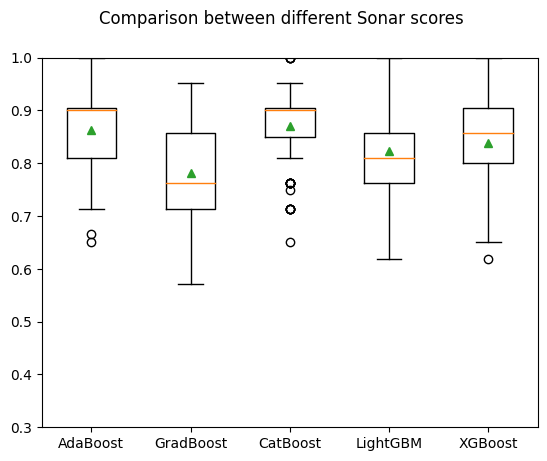

In [217]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Sonar scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(sonar_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [218]:
Algo_results['Sonar'] = sonar_mean

In [219]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar
0,AdaBoost,96.552288,97.159847,86.347619
1,GradBoost,98.075163,96.646633,78.145238
2,CatBoost,97.967320,97.378303,87.076190
3,LightGBM,97.120915,97.334612,82.361905
4,XGBoost,97.797386,96.792626,83.802381


In [220]:
Algo_time_results['Sonar'] = pd.Series(execution_times)

---

# **Ionosphere Dataset**

---

In [221]:
ionosphere_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Ionosphere\ionosphere.data', header=None)

In [222]:
ionosphere_df.shape

(351, 35)

In [223]:
X = ionosphere_df.iloc[:, :-1]
y = ionosphere_df.iloc[:, -1]

In [224]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [226]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [227]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [228]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [01:23<00:00,  1.66s/trial, best loss: -0.971830985915493] 
Best hyperparameters for AdaBoost:
{'n_estimators': 50.0, 'learning_rate': 0.046035205781861564, 'max_depth': 6.0, 'max_features': 'log2', 'min_samples_leaf': 5.0, 'min_samples_split': 2.0, 'random_state': 42}
100%|██████████| 50/50 [00:52<00:00,  1.06s/trial, best loss: -0.9295774647887324]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': None, 'n_estimators': 400, 'learning_rate': 0.021178191623985942, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 2.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [06:43<00:00,  8.07s/trial, best loss: -0.9577464788732394]
Best hyperparameters for CatBoost:
{'n_estimators': 750, 'learning_rate': 0.02983152512960275, 'min_child_samples': 3, 'max_depth': 5, 'reg_lambda': 3.8771604915102147, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 [

In [229]:
ionosphere_scores = []
ionosphere_mean = []
ionosphere_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)
        
    start_time = time.time()    
    results = cross_val_score(clf, X, y, cv=rskf)
    end_time = time.time()
    ionosphere_scores.append(results)
    ionosphere_mean.append(results.mean()*100)
    ionosphere_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)
    print(f'--------- {algorithm_name} on Ionosphere Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on Ionosphere Dataset ---------
[1.         0.91428571 0.91428571 0.94285714 0.97142857 0.91428571
 0.94285714 0.97142857 0.97142857 0.88571429 0.97222222 0.94285714
 0.97142857 0.97142857 1.         0.94285714 0.91428571 0.88571429
 0.91428571 0.88571429 0.86111111 0.85714286 0.97142857 0.94285714
 0.97142857 0.94285714 1.         0.94285714 0.88571429 1.
 0.91666667 0.97142857 0.94285714 1.         0.91428571 0.91428571
 0.85714286 0.91428571 0.94285714 0.88571429 0.97222222 1.
 0.91428571 0.91428571 0.97142857 0.82857143 1.         0.97142857
 0.91428571 0.85714286 0.94444444 0.97142857 0.91428571 1.
 0.94285714 0.97142857 0.97142857 0.91428571 0.91428571 0.88571429
 0.97222222 0.91428571 0.91428571 0.94285714 0.97142857 0.91428571
 1.         0.88571429 1.         0.94285714 0.97222222 0.88571429
 0.91428571 0.94285714 0.88571429 0.88571429 1.         0.91428571
 0.97142857 1.         0.91666667 0.94285714 0.94285714 0.97142857
 0.8        1.         0.91428571 1

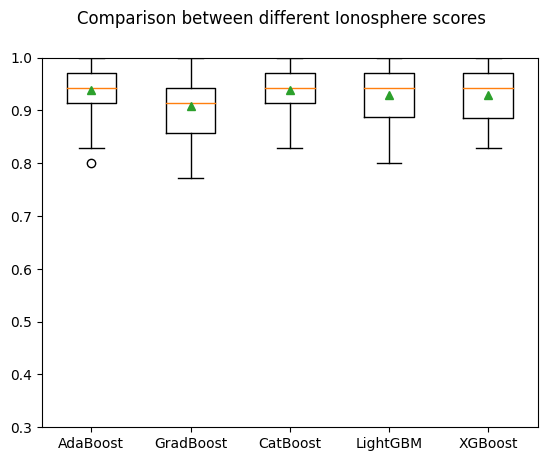

In [230]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Ionosphere scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(ionosphere_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [231]:
Algo_results['Ionosphere'] = ionosphere_mean

In [232]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere
0,AdaBoost,96.552288,97.159847,86.347619,93.815873
1,GradBoost,98.075163,96.646633,78.145238,90.854762
2,CatBoost,97.967320,97.378303,87.076190,93.815079
3,LightGBM,97.120915,97.334612,82.361905,92.849206
4,XGBoost,97.797386,96.792626,83.802381,92.960317


In [233]:
Algo_time_results['Ionosphere'] = pd.Series(execution_times)

---

# **Bupa**

---

In [247]:
bupa_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Bupa\Bupa.data', header=None)

In [248]:
bupa_df.shape

(345, 7)

In [249]:
X = bupa_df.iloc[:, :-1]
y = bupa_df.iloc[:, -1]

In [250]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [252]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [01:06<00:00,  1.33s/trial, best loss: -0.8695652173913043]
Best hyperparameters for AdaBoost:
{'n_estimators': 1150.0, 'learning_rate': 0.036566586849114326, 'max_depth': 6.0, 'max_features': 'sqrt', 'min_samples_leaf': 3.0, 'min_samples_split': 2.0, 'random_state': 42}
100%|██████████| 50/50 [00:19<00:00,  2.59trial/s, best loss: -0.8115942028985508]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': None, 'n_estimators': 650, 'learning_rate': 0.06856648459048352, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 0.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [01:01<00:00,  1.23s/trial, best loss: -0.7971014492753623]
Best hyperparameters for CatBoost:
{'n_estimators': 1000, 'learning_rate': 0.07885766008379519, 'min_child_samples': 8, 'max_depth': 2, 'reg_lambda': 2.215819236413667, 'silent': True, 'random_state': 42}
100%|██████████| 50/50

In [253]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [254]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [255]:
bupa_scores = []
bupa_mean = []
bupa_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)

    start_time = time.time()    
    results = cross_val_score(clf, X, y, cv=rskf)
    end_time = time.time()
    bupa_scores.append(results)
    bupa_mean.append(results.mean()*100)
    bupa_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)
    print(f'--------- {algorithm_name} on Bupa Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on Bupa Dataset ---------
[0.77142857 0.74285714 0.71428571 0.71428571 0.77142857 0.88235294
 0.67647059 0.64705882 0.67647059 0.61764706 0.65714286 0.57142857
 0.68571429 0.8        0.68571429 0.70588235 0.70588235 0.76470588
 0.73529412 0.67647059 0.65714286 0.71428571 0.8        0.74285714
 0.77142857 0.70588235 0.79411765 0.73529412 0.70588235 0.67647059
 0.77142857 0.77142857 0.74285714 0.82857143 0.74285714 0.79411765
 0.64705882 0.70588235 0.70588235 0.67647059 0.74285714 0.8
 0.65714286 0.68571429 0.77142857 0.73529412 0.73529412 0.64705882
 0.67647059 0.70588235 0.65714286 0.77142857 0.74285714 0.62857143
 0.77142857 0.70588235 0.70588235 0.70588235 0.58823529 0.58823529
 0.74285714 0.77142857 0.6        0.57142857 0.68571429 0.73529412
 0.61764706 0.82352941 0.85294118 0.67647059 0.8        0.65714286
 0.82857143 0.74285714 0.65714286 0.79411765 0.76470588 0.70588235
 0.67647059 0.73529412 0.8        0.68571429 0.71428571 0.82857143
 0.68571429 0.70588235 0

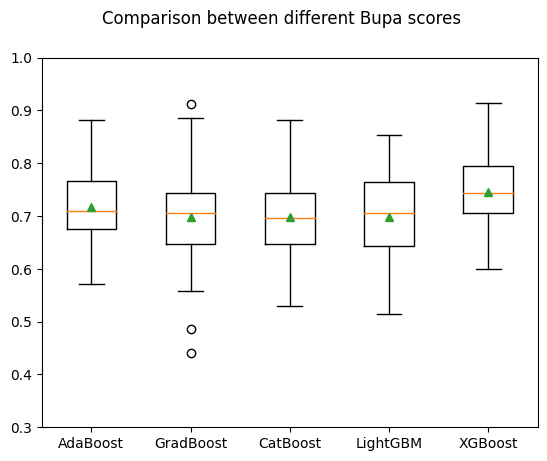

In [256]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Bupa scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(bupa_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [257]:
Algo_results['Bupa'] = bupa_mean

In [258]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,TicTacToe,Bupa
0,AdaBoost,96.552288,97.159847,86.347619,93.815873,81.054167,71.669748
1,GradBoost,98.075163,96.646633,78.145238,90.854762,82.224232,69.783193
2,CatBoost,97.967320,97.378303,87.076190,93.815079,72.318311,69.846218
3,LightGBM,97.120915,97.334612,82.361905,92.849206,61.814474,69.794118
4,XGBoost,97.797386,96.792626,83.802381,92.960317,65.721053,74.475630


In [259]:
Algo_time_results['Bupa'] = pd.Series(execution_times)

---

# **Pima**

---

In [260]:
pima_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Pima\Diabetes.csv')

In [261]:
X = pima_df.iloc[:, :-1]
y = pima_df.iloc[:, -1]

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [263]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [01:36<00:00,  1.94s/trial, best loss: -0.7857142857142857]
Best hyperparameters for AdaBoost:
{'n_estimators': 1500.0, 'learning_rate': 0.010436960322525368, 'max_depth': 1.0, 'max_features': None, 'min_samples_leaf': 5.0, 'min_samples_split': 4.0, 'random_state': 42}
100%|██████████| 50/50 [00:25<00:00,  1.98trial/s, best loss: -0.7922077922077922]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': 'sqrt', 'n_estimators': 200, 'learning_rate': 0.05871692740564188, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 2.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [01:12<00:00,  1.45s/trial, best loss: -0.7792207792207793]
Best hyperparameters for CatBoost:
{'n_estimators': 50, 'learning_rate': 0.010922414344918462, 'min_child_samples': 10, 'max_depth': 4, 'reg_lambda': 4.685483905860218, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 

In [264]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [265]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [266]:
pima_scores = []
pima_mean = []
pima_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)

    start_time = time.time()     
    results = cross_val_score(clf, X, y, cv=rskf)
    end_time = time.time()
    pima_scores.append(results)
    pima_mean.append(results.mean()*100)
    pima_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)
    print(f'--------- {algorithm_name} on Pima Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on Pima Dataset ---------
[0.80519481 0.76623377 0.75324675 0.85714286 0.81818182 0.74025974
 0.74025974 0.71428571 0.75       0.69736842 0.77922078 0.7012987
 0.75324675 0.74025974 0.74025974 0.84415584 0.80519481 0.72727273
 0.73684211 0.82894737 0.81818182 0.74025974 0.77922078 0.68831169
 0.75324675 0.76623377 0.74025974 0.81818182 0.71052632 0.69736842
 0.80519481 0.75324675 0.76623377 0.77922078 0.79220779 0.74025974
 0.77922078 0.80519481 0.76315789 0.67105263 0.76623377 0.77922078
 0.84415584 0.81818182 0.80519481 0.75324675 0.68831169 0.77922078
 0.73684211 0.69736842 0.76623377 0.77922078 0.76623377 0.72727273
 0.76623377 0.80519481 0.71428571 0.74025974 0.76315789 0.72368421
 0.76623377 0.74025974 0.75324675 0.76623377 0.71428571 0.83116883
 0.74025974 0.74025974 0.76315789 0.75       0.80519481 0.75324675
 0.72727273 0.84415584 0.74025974 0.74025974 0.77922078 0.72727273
 0.75       0.73684211 0.72727273 0.72727273 0.79220779 0.79220779
 0.77922078 0.8181

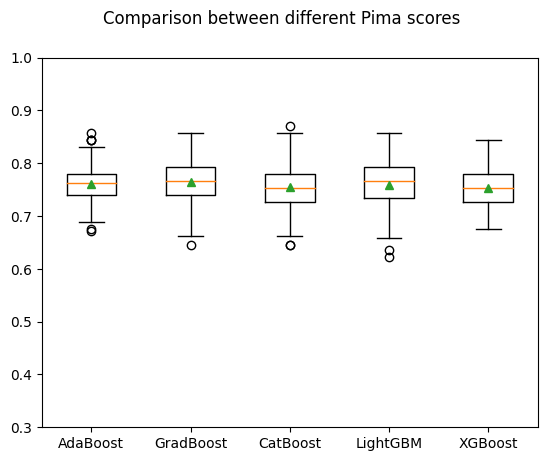

In [267]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Pima scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(pima_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [268]:
Algo_results['Pima'] = pima_mean

In [269]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,TicTacToe,Bupa,Pima
0,AdaBoost,96.552288,97.159847,86.347619,93.815873,81.054167,71.669748,76.101504
1,GradBoost,98.075163,96.646633,78.145238,90.854762,82.224232,69.783193,76.426863
2,CatBoost,97.967320,97.378303,87.076190,93.815079,72.318311,69.846218,75.527683
3,LightGBM,97.120915,97.334612,82.361905,92.849206,61.814474,69.794118,75.920711
4,XGBoost,97.797386,96.792626,83.802381,92.960317,65.721053,74.475630,75.334074


In [270]:
Algo_time_results['Pima'] = pd.Series(execution_times)

---

# **Heart**

---

In [271]:
heart_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Heart\Heart.csv')

In [272]:
X = heart_df.iloc[:, :-1]
y = heart_df.iloc[:, -1]

In [273]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [274]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [275]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [00:54<00:00,  1.09s/trial, best loss: -0.8888888888888888]
Best hyperparameters for AdaBoost:
{'n_estimators': 600.0, 'learning_rate': 0.03167747886969513, 'max_depth': 1.0, 'max_features': None, 'min_samples_leaf': 3.0, 'min_samples_split': 4.0, 'random_state': 42}
100%|██████████| 50/50 [00:20<00:00,  2.43trial/s, best loss: -0.8703703703703703]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': None, 'n_estimators': 850, 'learning_rate': 0.053611707225416305, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 0.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [00:45<00:00,  1.09trial/s, best loss: -0.9074074074074074]
Best hyperparameters for CatBoost:
{'n_estimators': 100, 'learning_rate': 0.06012626813664707, 'min_child_samples': 6, 'max_depth': 5, 'reg_lambda': 3.702478129069811, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 [0

In [276]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [277]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [278]:
heart_scores = []
heart_mean = []
heart_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)

    start_time = time.time()    
    results = cross_val_score(clf, X, y, cv=rskf)
    end_time = time.time()
    heart_scores.append(results)
    heart_mean.append(results.mean()*100)
    heart_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)
    print(f'--------- {algorithm_name} on Heart Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on Heart Dataset ---------
[0.81481481 0.81481481 0.81481481 0.96296296 0.77777778 0.77777778
 0.88888889 0.77777778 0.77777778 0.96296296 0.85185185 0.77777778
 0.88888889 0.81481481 0.85185185 0.85185185 0.92592593 0.62962963
 0.81481481 0.85185185 0.77777778 0.96296296 0.81481481 0.77777778
 0.92592593 0.81481481 0.85185185 0.74074074 0.81481481 0.88888889
 0.81481481 0.88888889 0.85185185 0.81481481 0.81481481 0.88888889
 0.81481481 0.77777778 0.85185185 0.77777778 0.81481481 0.96296296
 0.74074074 0.85185185 0.7037037  0.88888889 0.77777778 0.88888889
 0.77777778 0.88888889 0.66666667 0.81481481 0.85185185 0.81481481
 0.77777778 0.88888889 0.81481481 0.81481481 0.81481481 0.88888889
 0.85185185 0.88888889 0.85185185 0.88888889 0.85185185 0.77777778
 0.85185185 0.74074074 0.77777778 0.92592593 0.88888889 0.85185185
 0.77777778 0.85185185 0.77777778 0.81481481 0.77777778 0.85185185
 0.81481481 0.85185185 0.92592593 0.85185185 0.85185185 0.85185185
 0.74074074 0.85

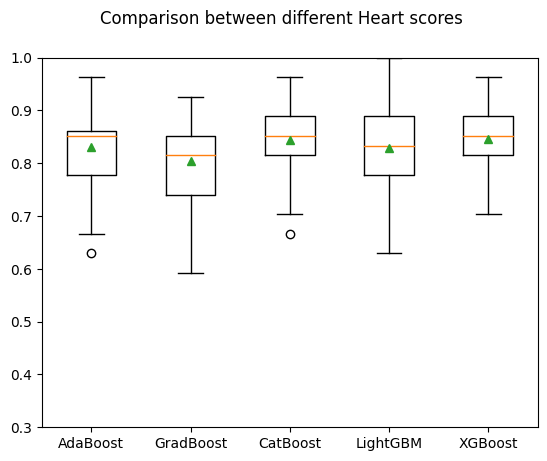

In [279]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Heart scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(heart_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [280]:
Algo_results['Heart'] = heart_mean

In [281]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,TicTacToe,Bupa,Pima,Heart
0,AdaBoost,96.552288,97.159847,86.347619,93.815873,81.054167,71.669748,76.101504,83.111111
1,GradBoost,98.075163,96.646633,78.145238,90.854762,82.224232,69.783193,76.426863,80.444444
2,CatBoost,97.967320,97.378303,87.076190,93.815079,72.318311,69.846218,75.527683,84.481481
3,LightGBM,97.120915,97.334612,82.361905,92.849206,61.814474,69.794118,75.920711,82.851852
4,XGBoost,97.797386,96.792626,83.802381,92.960317,65.721053,74.475630,75.334074,84.518519


In [282]:
Algo_time_results['Heart'] = pd.Series(execution_times)

---

# **Liver**

---

In [283]:
liver_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Liver\Bupa.data', header=None)

In [284]:
X = liver_df.iloc[:, :-1]
y = liver_df.iloc[:, -1]

In [285]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [286]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [00:54<00:00,  1.10s/trial, best loss: -0.8888888888888888]
Best hyperparameters for AdaBoost:
{'n_estimators': 600.0, 'learning_rate': 0.03167747886969513, 'max_depth': 1.0, 'max_features': None, 'min_samples_leaf': 3.0, 'min_samples_split': 4.0, 'random_state': 42}
100%|██████████| 50/50 [00:20<00:00,  2.44trial/s, best loss: -0.8703703703703703]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': None, 'n_estimators': 850, 'learning_rate': 0.053611707225416305, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 0.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [00:45<00:00,  1.10trial/s, best loss: -0.9074074074074074]
Best hyperparameters for CatBoost:
{'n_estimators': 100, 'learning_rate': 0.06012626813664707, 'min_child_samples': 6, 'max_depth': 5, 'reg_lambda': 3.702478129069811, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 [0

In [287]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [288]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [289]:
liver_scores = []
liver_mean = []
liver_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)

    start_time = time.time()    
    results = cross_val_score(clf, X, y, cv=rskf)
    end_time = time.time()
    liver_scores.append(results)
    liver_mean.append(results.mean()*100)
    liver_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)
    print(f'--------- {algorithm_name} on Liver Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on Liver Dataset ---------
[0.85714286 0.8        0.65714286 0.77142857 0.62857143 0.85294118
 0.82352941 0.64705882 0.61764706 0.79411765 0.8        0.65714286
 0.62857143 0.82857143 0.8        0.73529412 0.79411765 0.73529412
 0.76470588 0.76470588 0.62857143 0.62857143 0.77142857 0.82857143
 0.85714286 0.85294118 0.82352941 0.67647059 0.70588235 0.76470588
 0.8        0.8        0.74285714 0.85714286 0.77142857 0.76470588
 0.64705882 0.70588235 0.73529412 0.64705882 0.74285714 0.77142857
 0.68571429 0.57142857 0.82857143 0.79411765 0.76470588 0.64705882
 0.73529412 0.76470588 0.71428571 0.77142857 0.74285714 0.65714286
 0.77142857 0.76470588 0.76470588 0.82352941 0.70588235 0.70588235
 0.68571429 0.88571429 0.65714286 0.68571429 0.74285714 0.67647059
 0.70588235 0.82352941 0.88235294 0.64705882 0.74285714 0.65714286
 0.82857143 0.77142857 0.74285714 0.79411765 0.79411765 0.61764706
 0.73529412 0.70588235 0.68571429 0.71428571 0.77142857 0.8
 0.74285714 0.67647059 

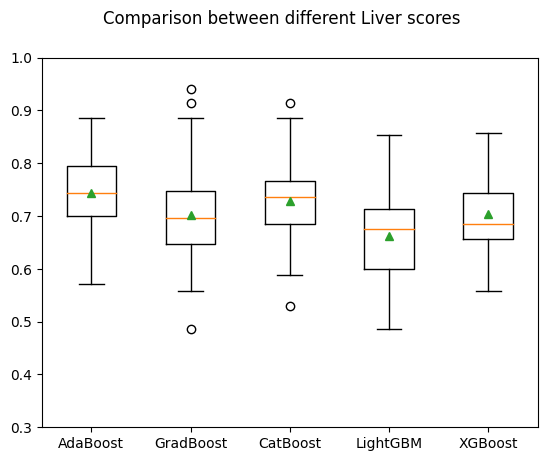

In [290]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Liver scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(liver_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [291]:
Algo_results['Liver'] = liver_mean

In [292]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,TicTacToe,Bupa,Pima,Heart,Liver
0,AdaBoost,96.552288,97.159847,86.347619,93.815873,81.054167,71.669748,76.101504,83.111111,74.378992
1,GradBoost,98.075163,96.646633,78.145238,90.854762,82.224232,69.783193,76.426863,80.444444,70.185714
2,CatBoost,97.967320,97.378303,87.076190,93.815079,72.318311,69.846218,75.527683,84.481481,72.915126
3,LightGBM,97.120915,97.334612,82.361905,92.849206,61.814474,69.794118,75.920711,82.851852,66.281513
4,XGBoost,97.797386,96.792626,83.802381,92.960317,65.721053,74.475630,75.334074,84.518519,70.308403


In [293]:
Tuned_Algo_results_tr = Algo_results.set_index('Names').T

In [294]:
Tuned_Algo_results_tr.to_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Algo_Results\TunedAlgoResults.csv', index=False)

In [295]:
Tuned_Algo_results_tr

Names,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
Wine,96.552288,98.075163,97.967320,97.120915,97.797386
Breast_Cancer,97.159847,96.646633,97.378303,97.334612,96.792626
Sonar,86.347619,78.145238,87.076190,82.361905,83.802381
Ionosphere,93.815873,90.854762,93.815079,92.849206,92.960317
TicTacToe,81.054167,82.224232,72.318311,61.814474,65.721053
Bupa,71.669748,69.783193,69.846218,69.794118,74.475630
Pima,76.101504,76.426863,75.527683,75.920711,75.334074
Heart,83.111111,80.444444,84.481481,82.851852,84.518519
Liver,74.378992,70.185714,72.915126,66.281513,70.308403


In [296]:
Algo_time_results['Liver'] = pd.Series(execution_times)

In [297]:
Algo_time_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,TicTacToe,Bupa,Pima,Heart,Liver
0,AdaBoost,22.876993,61.194410,684.942121,12.945922,180.591471,170.621086,242.872719,72.530710,75.069522
1,GradBoost,16.068150,21.079964,8.578935,101.464809,218.208239,50.943508,10.406996,65.325738,61.445898
2,CatBoost,97.146326,45.571171,777.298369,175.465500,66.157809,97.110876,14.647845,16.624023,16.569025
3,LightGBM,3.337753,1.491335,1.497339,2.713613,5.699997,1.671589,2.365534,0.788177,0.830725
4,XGBoost,40.201234,17.142870,21.754911,4.676054,5.930719,16.036321,3.706836,3.511206,2.912373


In [298]:
Tuned_Algo_time_results_tr = Algo_time_results.set_index('Names').T

In [299]:
Tuned_Algo_time_results_tr.to_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Algo_Results\TunedAlgoTimeResults.csv', index=False)

---

# **Friedman's Test**

---

In [124]:
!pip install scikit-posthocs

In [4]:
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare

In [5]:
Tuned_Algo_results_tr = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Algo_Results\TunedAlgoResults.csv')

In [6]:
Tuned_Algo_results_tr

,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
0,96.552288,98.075163,97.967320,97.120915,97.797386
1,97.159847,96.646633,97.378303,97.334612,96.792626
2,86.347619,78.145238,87.076190,82.361905,83.802381
3,93.815873,90.854762,93.815079,92.849206,92.960317
4,81.054167,82.224232,72.318311,61.814474,65.721053
5,71.669748,69.783193,69.846218,69.794118,74.475630
6,76.101504,76.426863,75.527683,75.920711,75.334074
7,83.111111,80.444444,84.481481,82.851852,84.518519
8,74.378992,70.185714,72.915126,66.281513,70.308403


In [7]:
stat, p_value = friedmanchisquare(Tuned_Algo_results_tr['AdaBoost'], Tuned_Algo_results_tr['GradBoost'], Tuned_Algo_results_tr['CatBoost'], Tuned_Algo_results_tr['LightGBM'], Tuned_Algo_results_tr['XGBoost'])

In [8]:
p_value

0.10184966488235873

In [9]:
alpha = 0.05
if p_value < alpha:
    print('There are significant differences among the models.')
else:
    print('There are no significant differences among the models.')

There are no significant differences among the models.


---

# **Algorithms running time Friedman's Test**

---

In [10]:
Tuned_Algo_results_tr = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Algo_Results\TunedAlgoTimeResults.csv')

In [11]:
Tuned_Algo_results_tr

,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
0,22.876993,16.068150,97.146326,3.337753,40.201234
1,61.194410,21.079964,45.571171,1.491335,17.142870
2,684.942121,8.578935,777.298369,1.497339,21.754911
3,12.945922,101.464809,175.465500,2.713613,4.676054
4,180.591471,218.208239,66.157809,5.699997,5.930719
5,170.621086,50.943508,97.110876,1.671589,16.036321
6,242.872719,10.406996,14.647845,2.365534,3.706836
7,72.530710,65.325738,16.624023,0.788177,3.511206
8,75.069522,61.445898,16.569025,0.830725,2.912373


In [12]:
stat, p_value = friedmanchisquare(Tuned_Algo_results_tr['AdaBoost'], Tuned_Algo_results_tr['GradBoost'], Tuned_Algo_results_tr['CatBoost'], Tuned_Algo_results_tr['LightGBM'], Tuned_Algo_results_tr['XGBoost'])

In [13]:
p_value

2.627853700566302e-05

In [15]:
alpha = 0.05
if p_value < alpha:
    print('There are significant running time differences among the algorithm.')
else:
    print('There are no significant running time differences among the algorithm.')

There are significant running time differences among the algorithm.


---

# **Algorithms running time Nemenyi test**

---

In [17]:
nemenyi_results = sp.posthoc_nemenyi_friedman(a=Tuned_Algo_results_tr)

In [18]:
nemenyi_results

,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
AdaBoost,1.000000,0.643932,0.900000,0.001000,0.056476
GradBoost,0.643932,1.000000,0.897740,0.015044,0.643932
CatBoost,0.900000,0.897740,1.000000,0.001000,0.166548
LightGBM,0.001000,0.015044,0.001000,1.000000,0.381128
XGBoost,0.056476,0.643932,0.166548,0.381128,1.000000


In [20]:
alpha = 0.05

# Print p-values for all pairs of models
for i in range(nemenyi_results.shape[0]):
    for j in range(i + 1, nemenyi_results.shape[1]):
        model1 = i + 1
        model2 = j + 1
        p_value = nemenyi_results.iloc[i, j]

        if p_value < alpha:
            print(f"Algorithm {model1} and {model2} are significantly different (p-value = {p_value:.4f}).")
        else:
            print(f"Algorithm {model1} and {model2} are not significantly different (p-value = {p_value:.4f}).")

Algorithm 1 and 2 are not significantly different (p-value = 0.6439).
Algorithm 1 and 3 are not significantly different (p-value = 0.9000).
Algorithm 1 and 4 are significantly different (p-value = 0.0010).
Algorithm 1 and 5 are not significantly different (p-value = 0.0565).
Algorithm 2 and 3 are not significantly different (p-value = 0.8977).
Algorithm 2 and 4 are significantly different (p-value = 0.0150).
Algorithm 2 and 5 are not significantly different (p-value = 0.6439).
Algorithm 3 and 4 are significantly different (p-value = 0.0010).
Algorithm 3 and 5 are not significantly different (p-value = 0.1665).
Algorithm 4 and 5 are not significantly different (p-value = 0.3811).


---

# **Comparison between the untuned and tuned algorithm performance**

---

In [21]:
import scipy.stats as stats

In [22]:
untuned_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Algo_Results\AlgoResults.csv')
tuned_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Algo_Results\TunedAlgoResults.csv')

In [23]:
print(untuned_df.shape)
print(tuned_df.shape)

(9, 5)
(9, 5)


In [24]:
datasets = ['Wine', 'Breast Cancer', 'Sonar', 'Ionosphere', 'Bupa', 'Pima', 'Heart', 'Liver']

## **AdaBoost**

In [66]:
AdaBoost_before_array = []

for i, name in enumerate(datasets):
    AdaBoost_value = untuned_df.iloc[i, :]['AdaBoost']
    AdaBoost_before_array.append(AdaBoost_value)

AdaBoost_before = np.array(AdaBoost_before_array)

In [67]:
AdaBoost_before

array([89.83006536, 95.80051151, 83.18809524, 93.02777778, 73.70745614,
       72.25462185, 75.11859193, 79.81481481, 72.25462185])

In [70]:
AdaBoost_after_array = []

for i, name in enumerate(datasets):
    AdaBoost_value = tuned_df.iloc[i, :]['AdaBoost']
    AdaBoost_after_array.append(AdaBoost_value)

AdaBoost_after = np.array(AdaBoost_after_array)
 

In [71]:
AdaBoost_after

array([96.55228758, 97.15984655, 86.34761905, 93.81587302, 81.05416667,
       71.6697479 , 76.10150376, 83.11111111, 74.3789916 ])

In [72]:
statistic, p_value = stats.wilcoxon(AdaBoost_before, AdaBoost_after)

In [74]:
print(f"Test Statistic: {statistic}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print(f'Reject the null hypothesis: There is a significant difference between AdaBoost algorithm.')
else:
    print(f'Fail to reject the null hypothesis: There is no significant difference between AdaBoost algorithm.')      

Test Statistic: 1.0
P-value: 0.0078125
Reject the null hypothesis: There is a significant difference between AdaBoost algorithm.


## **GradBoost**

In [83]:
GradBoost_before_array = []

for i, name in enumerate(datasets):
    GradBoost_value = untuned_df.iloc[i, :]['GradBoost']
    GradBoost_before_array.append(GradBoost_value)

GradBoost_before = np.array(GradBoost_before_array)

In [84]:
GradBoost_before

array([95.01633987, 96.5741688 , 84.27619048, 92.94365079, 64.35471491,
       72.44033613, 76.2359877 , 80.07407407, 72.29243697])

In [85]:
GradBoost_after_array = []

for i, name in enumerate(datasets):
    GradBoost_value = tuned_df.iloc[i, :]['GradBoost']
    GradBoost_after_array.append(GradBoost_value)

GradBoost_after = np.array(GradBoost_after_array)
 

In [86]:
GradBoost_after

array([98.0751634 , 96.64663257, 78.1452381 , 90.8547619 , 82.22423246,
       69.78319328, 76.42686261, 80.44444444, 70.18571429])

In [87]:
statistic, p_value = stats.wilcoxon(GradBoost_before, GradBoost_after)

In [88]:
print(f"Test Statistic: {statistic}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print(f'Reject the null hypothesis: There is a significant difference between GradBoost algorithm.')
else:
    print(f'Fail to reject the null hypothesis: There is no significant difference between GradBoost algorithm.')      

Test Statistic: 22.0
P-value: 1.0
Fail to reject the null hypothesis: There is no significant difference between GradBoost algorithm.


## **CatBoost**

In [96]:
CatBoost_before_array = []

for i, name in enumerate(datasets):
    CatBoost_value = untuned_df.iloc[i, :]['CatBoost']
    CatBoost_before_array.append(CatBoost_value)

CatBoost_before = np.array(CatBoost_before_array)

In [97]:
CatBoost_before

array([97.97712418, 97.08716965, 87.15238095, 93.4531746 , 51.49122807,
       74.40336134, 76.24931647, 81.88888889, 74.40336134])

In [98]:
CatBoost_after_array = []

for i, name in enumerate(datasets):
    CatBoost_value = tuned_df.iloc[i, :]['CatBoost']
    CatBoost_after_array.append(CatBoost_value)

CatBoost_after = np.array(CatBoost_after_array)
 

In [99]:
CatBoost_after

array([97.96732026, 97.3783035 , 87.07619048, 93.81507937, 72.3183114 ,
       69.84621849, 75.52768284, 84.48148148, 72.91512605])

In [100]:
statistic, p_value = stats.wilcoxon(CatBoost_before, CatBoost_after)

In [101]:
print(f"Test Statistic: {statistic}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print(f'Reject the null hypothesis: There is a significant difference between CatBoost algorithm.')
else:
    print(f'Fail to reject the null hypothesis: There is no significant difference between CatBoost algorithm.')      

Test Statistic: 22.0
P-value: 1.0
Fail to reject the null hypothesis: There is no significant difference between CatBoost algorithm.


## **LightGBM**

In [102]:
LightGBM_before_array = []

for i, name in enumerate(datasets):
    LightGBM_value = untuned_df.iloc[i, :]['LightGBM']
    LightGBM_before_array.append(LightGBM_value)

LightGBM_before = np.array(LightGBM_before_array)

In [103]:
LightGBM_before

array([97.42156863, 96.63299233, 88.12380952, 93.70634921, 55.96151316,
       71.80168067, 73.98513329, 80.88888889, 71.80168067])

In [104]:
LightGBM_after_array = []

for i, name in enumerate(datasets):
    LightGBM_value = tuned_df.iloc[i, :]['LightGBM']
    LightGBM_after_array.append(LightGBM_value)

LightGBM_after = np.array(LightGBM_after_array)
 

In [105]:
LightGBM_after

array([97.12091503, 97.33461211, 82.36190476, 92.84920635, 61.81447368,
       69.79411765, 75.92071087, 82.85185185, 66.28151261])

In [106]:
statistic, p_value = stats.wilcoxon(LightGBM_before, LightGBM_after)

In [107]:
print(f"Test Statistic: {statistic}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print(f'Reject the null hypothesis: There is a significant difference between LightGBM algorithm.')
else:
    print(f'Fail to reject the null hypothesis: There is no significant difference between LightGBM algorithm.')      

Test Statistic: 20.0
P-value: 0.8203125
Fail to reject the null hypothesis: There is no significant difference between LightGBM algorithm.


## **XGBoost**

In [108]:
XGBoost_before_array = []

for i, name in enumerate(datasets):
    XGBoost_value = untuned_df.iloc[i, :]['XGBoost']
    XGBoost_before_array.append(XGBoost_value)

XGBoost_before = np.array(XGBoost_before_array)

In [109]:
XGBoost_before

array([96.67647059, 96.42902813, 85.00714286, 92.43015873, 45.98881579,
       70.57983193, 73.84244703, 80.37037037, 70.57983193])

In [111]:
XGBoost_after_array = []

for i, name in enumerate(datasets):
    XGBoost_value = tuned_df.iloc[i, :]['XGBoost']
    XGBoost_after_array.append(XGBoost_value)

XGBoost_after = np.array(XGBoost_after_array)
 

In [112]:
XGBoost_after

array([97.79738562, 96.79262575, 83.80238095, 92.96031746, 65.72105263,
       74.47563025, 75.33407382, 84.51851852, 70.30840336])

In [113]:
statistic, p_value = stats.wilcoxon(XGBoost_before, XGBoost_after)

In [114]:
print(f"Test Statistic: {statistic}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print(f'Reject the null hypothesis: There is a significant difference between XGBoost algorithm.')
else:
    print(f'Fail to reject the null hypothesis: There is no significant difference between XGBoost algorithm.')      

Test Statistic: 6.0
P-value: 0.0546875
Fail to reject the null hypothesis: There is no significant difference between XGBoost algorithm.
